In [23]:
%run base.ipynb
%matplotlib inline

from typing import Tuple

import matplotlib.pylab as plt
import pandas as pd
import torch as t
from fcast.domain.time_series import TimeSeries
from random import gauss
from rpy2 import robjects

from m4.data.dataset_extractor import M4DatasetExtractor, M4DatasetGroup
from m4.pipeline.adaptors import dataframe_to_r_ts_object
from m4.pipeline.forecaster.m4_baselines import theta as theta_forecaster
from m4.pipeline.model.R.utils import RForecastField, get_dataframe

### Prepare Data

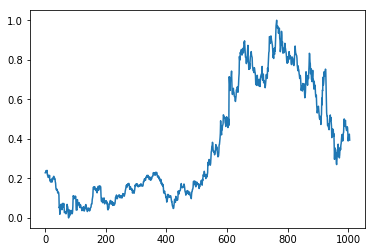

In [24]:
group = M4DatasetGroup.daily
index = 1
horizon = 14

raw_ts = M4DatasetExtractor(dataset_path='/projects/eai-m4/dataset', group=group).training_set()[index].data
scaled_ts = minmax_scale(raw_ts)

white_noise = pd.DataFrame([gauss(0.0, 1.0) for _ in range(1000)])

data = scaled_ts
plt.plot(data)
plt.show()


### Models

In [17]:
class TSLSTM(t.nn.Module, Model):
    def __init__(self, hidden_size, num_layers, optim, loss):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_size = 1
        self.optim = optim
        self.loss = loss
        self.training_losses = []
        
        self.lstm = t.nn.LSTM(input_size=1,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True
                             )
        self.output_layer = t.nn.Linear(in_features=hidden_size, out_features=1)                          
        self.state = self.__init_state()
        
    def update(self, df: pd.DataFrame) -> None:
        # init
        x = df_to_tensor(df)
        optim = self.optim(self.parameters())
        self.__reset_state()
        # forward pass
        prediction = self(x[:, :-1, :])
        # calculate and store loss
        loss_fn = self.loss(prediction, x[:, 1:, :])
        self.training_losses.append(float(loss_fn))
        # backprop
        loss_fn.backward()
        optim.step()
    
    def predict(self, df: pd.DataFrame, forecast_horizon: int) -> pd.DataFrame:
        self.__reset_state()        
        prediction = self(df_to_tensor(df))
        insample = prediction[:, :-1, :]
        outsample = [prediction[:, -1:, :]]
        
        while len(outsample) <= forecast_horizon:
            outsample.append(self(outsample[-1]))
            
        insample_df = tensor_to_df(insample, df)
        result = insample_df.shift(1)
        for outsample_result in outsample:
            result = pd.concat([result, tensor_to_df(outsample_result, df)], axis=0, ignore_index=True)
        return result
    
    def forward(self, x):
        output, self.state = self.lstm(x, self.state)
        output = self.output_layer(output)
        return output        
    
    def __reset_state(self) -> None:
        self.state = self.__init_state()
    
    def __init_state(self) -> Tuple[t.Tensor, t.Tensor]:
        return (t.zeros(self.num_layers, self.batch_size, self.hidden_size),
                t.zeros(self.num_layers, self.batch_size, self.hidden_size))
        

#
# Theta
#
class Theta(Model):
    def __init__(self):
        r_source = robjects.r['source']
        r_source("/usr/src/app/m4/pipeline/model/R/theta_classic.R")
        self.__r_func = robjects.r['Theta.classic']
    
    def update(self, df: pd.DataFrame) -> None:
        pass
        
    def predict(self, df: pd.DataFrame, forecast_horizon: int) -> pd.DataFrame:
        r_forecast_obj = self.__r_func(dataframe_to_r_ts_object(df, 14), forecast_horizon)
        in_sample_forecast = get_dataframe(r_forecast_obj, RForecastField.in_sample)
        out_sample_forecast = get_dataframe(r_forecast_obj, RForecastField.out_sample)
        result = pd.concat([in_sample_forecast, out_sample_forecast], axis=0, ignore_index=True)
        result.columns = df.columns
        return result

In [38]:
naive = ('naive', Naive())
theta = ('theta', Theta())
lstm = ('lstm', TSLSTM(hidden_size=100, 
                       num_layers=1,
                       optim=lambda p: t.optim.Adam(p, lr=1e-4),
                       loss=t.nn.L1Loss(reduction='elementwise_mean')))

trainer = Trainer(
    models=dict([naive, theta, lstm]), 
    history=data[:-horizon], future=data[-horizon:],     
    training_loss_fn=L1, test_loss_fn=L1)

<IPython.core.display.Javascript object>


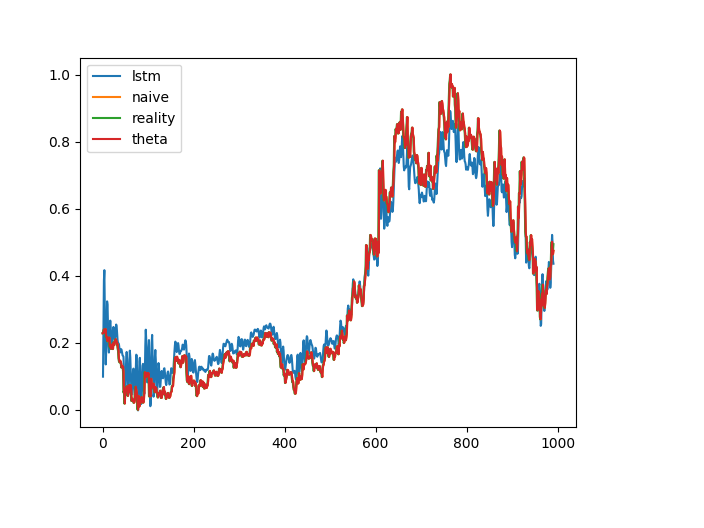

<IPython.core.display.Javascript object>


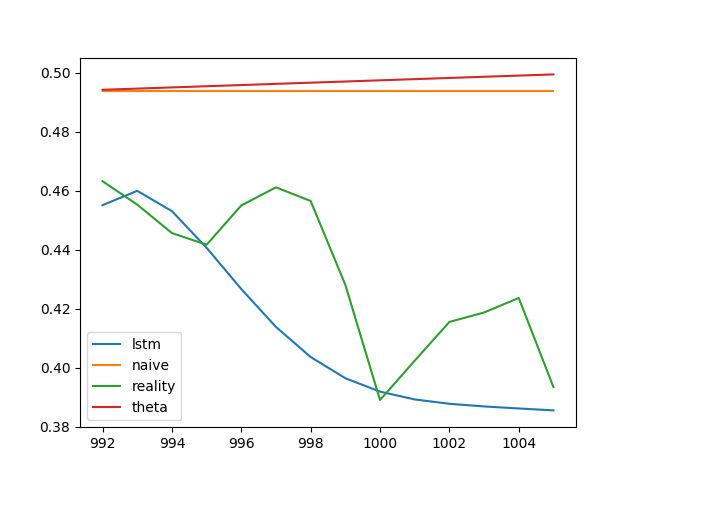

KeyboardInterrupt: 

In [48]:
for i in range(200):
    trainer.train()
    
    time_series = trainer.time_series
    
    plt.figure(num=1)
    plt.clf()
    for ts_name in list(time_series.columns.levels[0]):
        plt.plot(time_series[ts_name][:-horizon], label=ts_name)
    plt.legend()
    plt.gcf().canvas.draw()
    
    plt.figure(num=2)
    plt.clf()
    for ts_name in list(time_series.columns.levels[0]):
        plt.plot(time_series[ts_name][-horizon:], label=ts_name)
    plt.legend()
    plt.gcf().canvas.draw()
    
    

<IPython.core.display.Javascript object>


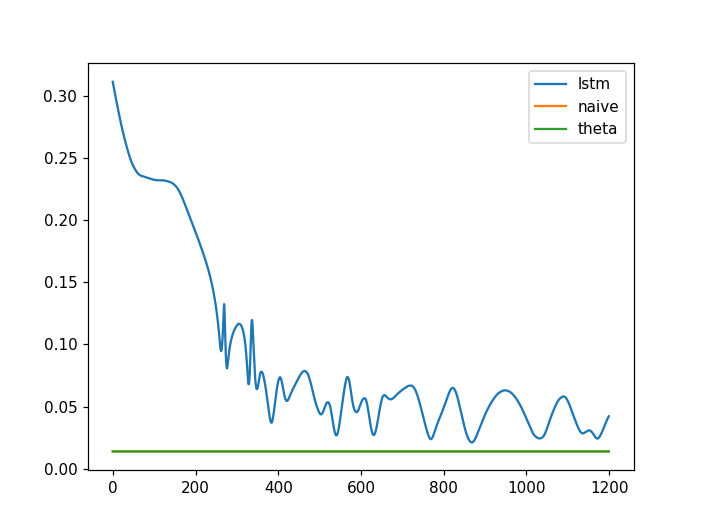

<IPython.core.display.Javascript object>


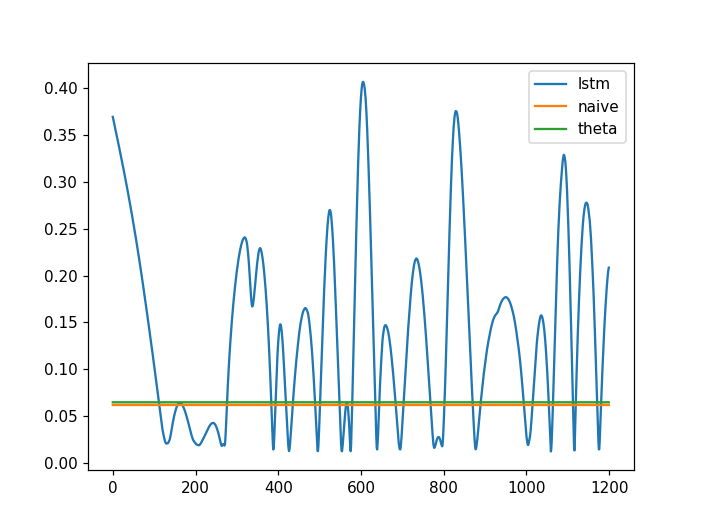

In [47]:
losses = trainer.losses

plt.figure(num=3)
plt.clf()
for model_name in list(losses.columns.levels[0]):
    plt.plot(losses[model_name]['train'], label=model_name)
plt.legend()
plt.gcf().canvas.draw()


plt.figure(num=4)
plt.clf()
for model_name in list(losses.columns.levels[0]):
    plt.plot(losses[model_name]['test'], label=model_name)
plt.legend()
plt.gcf().canvas.draw()

In [15]:
losses.columns.levels[0]

Index(['lstm', 'naive', 'theta'], dtype='object')

In [35]:
data.diff().abs().mean()

D2    0.013803
dtype: float64